# Hit Song Classifier

## Preprocessing

Preprocessing for the project includes processing of the _Billboard “The Hot 100” Songs_ dataset to determine classification according to the rankings of the songs and processing of the _Million Song Dataset_ for the songs that will need to be classified.

### Preprocessing: The _Billboard “The Hot 100” Songs_ dataset

The _Billboard “The Hot 100” Songs_ dataset is available via the Kaggle API at https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs. It includes the hot 100 songs from 1958 to 2021 (inclusive). Because the _Million Song Dataset_ includes titles from 1922 to 2010 preprocessing of the dataset includes filtering the list of songs so that titles more recent than 2010 are removed. The most important features of the dataset are “song”, “artist”, “rank”.
Preprocessing the _Billboard “The Hot 100” Songs_ dataset included 5 main steps:

1. Downloading the _Billboard “The Hot 100” Songs_ dataset from the Kaggle API. This dataset had no missing values for the columns: _song_, _artist_, and _rank_.
2. Processing the downloaded CSV file by removing titles more recent than 2010, then grouping by both the _song_ and the _artist_, and aggregating the results to take the minimum rank of each. The result of this processing is that for each _song_ and _artist_ pair, the minimum rank (highest billboard rank) is kept as it was determined that our project is only interested in the highest rank achieved for each song.
3. The next step in processing was to classify each of the data points such that ranks 1 to 10 were defined as class 0, ranks 11 to 20 were defined as class 1, and so on for each of the ranks up to 100.
4. The columns _song_, _artist_, and _class_ were then saved to a CSV file for the last data processing step where it is used to classify the _Million Song Dataset_ before it can be used to train our models.
5. As part of an effort to enhance the models, a new spotify dataset was processed and the billboard dataset was updated to include all available entries prior to 2023.
   Pyspark was determined to be the best tool for processing the _Billboard “The Hot 100” Songs_ dataset. The script can be found here in /src/preprocessing/billboard_preprocessor.py


### Preprocessing: The _Million Songs_ dataset

1. Downloading the Million songs dataset following this page's instructions: http://millionsongdataset.com/pages/getting-dataset/. Here is the link provided for the subset of 10,000 songs from the dataset: "http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz". There is a link for a relational database for the entire dataset. There is a download function that takes in a url in order to download the subset dataset.

2. Extract the dataset using the `extract_file` function that accepts the filepath of the downloaded file.

3. Obtain all the paths of the h5 files from the extracted dataset using the glob module and store them as a list.

4. For each h5 file, there are 3 groups that are of concern for song processing. They are the analysis, metadata, and musicbrainz groups. Each of them contain their own "songs" dataset with their own separate features for each song. Using the `read_hdf` of dask and each key being the name of the group followed by the name of the dataset(songs), read all the features of one group for every song into a single dataframe.

5. Merge all the songs using the concat method of dask where you specify `axis = 1` for a column wise concatenation.

6. Process the dataset in using the `process` function. Select which features of the dataset will be included and drop any songs with null values for any of its features.

7. Write the final dataframe to a csv file.

The million song dataset was not used in the final dataset for our models. We realized that the dataset had missing data for important features such as danceability as well as issues determining singles. This is due to the Million songs dataset having different titles compared to the Billboard “The Hot 100” Songs dataset for random songs. Another issue was the over representation of unranked songs from the million songs dataset that was affecting our model. We used Spotify's API to obtain the features necessary for the songs in the Billboard “The Hot 100” Songs dataset such as danceability. The Billboard “The Hot 100” Songs dataset had a large enough samples of songs where the performance would be fine on its own without the additional songs from the million songs dataset skewing the class distribution towards the unranked category.


### Preprocessing: Feature Engineering with the Spotify Web API

As you will see later, the original million song dataset is heavily skewed towards "not-hit" (i.e. Class `10`) songs. However, in order to stratify the differences in rank between songs that are on the Billboard Hot 100, we need a more evenly distributed dataset. Therefore, we decided to use the Billboard dataset as a foundation to search for music features that we can append to the dataset. Additionally, we could also expand the search space from the years 1958 up until 2022. This accomplishes two goals: (1) evenly distributes the dataset, (2) adds additional features that might be useful for ML.

#### Workflow:

1. Using the existing Billboard Hot 100 dataset, clean the title and song names since otherwise the Spotify Web API search query will return an HTTP `400` error (Bad Request).

2. Use Spotify Web API to perform a search query on the song title and artist, which returns a Spotify `track_id`.

3. Use the `track_id` to perform another API call to return a dictionary of audio features for the track, such as `[popularity, danceability, energy, key, mode, acousticness, etc.]`

4. Append features to Billboard Hot 100 dataset and call it the `spotify_enhanced_dataset`.

Since the Billboard Hot 100 dataset consists of over 30000 unique tuples, this requires over 30000 search API calls since searches can only be done sequentially. However, API calls for getting audio features can be batched up to 100 unique `track_id`s, which allowed us to reduce the audio feature API calls from over 30000 to just over 300.

The code for this feature engineering process can be found in `src/preprocessing/spotify_dataset_generator.py`. Be aware that Spotify sets rate limiting, and max API calls per user per day amount to between 10000 to 15000. Therefore we had to shard the dataset into tuples of 1000 and generate intermediate dataset files to save our progress. Otherwise, rate limiting will cause the process to stall, and inevitably lose all the data we painstakingly compiled when the program exits prematurely.

## Machine Learning

Full ML notebooks are available in `src/models` for Pyspark implementations of multiclass logistic regression and random forest classifiers (RFC). Scikit-learn implementations of multiclass SVM and RFC are available in `src/models/sklearn`.

In [4]:
# Define our imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


from pyspark.sql import DataFrame, SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import ConfusionMatrixDisplay

# Allocate enough memory for our Spark session
memory = "8g"
pyspark_submit_args = f"--driver-memory {memory} pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

# Define our constants
MILLION_DATA = "../data/join_datasets_with_class.csv"
MILLION_FEATURES = [
    "danceability",
    "duration",
    "energy",
    "key",
    "loudness",
    "song_hotttnesss",
    "tempo",
    "time_signature",
]
SPOTIFY_DATA = "../data/spotify_enhanced_dataset.csv"
SPOTIFY_FEATURES = [
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]
RESAMPLED_SPOTIFY_DATA = "../data/spotify_enhanced_dataset_regularized.csv"


RANDOM_SEED = 0


def feature_transformer(df: DataFrame, features: list) -> DataFrame:
    """Assembles feature vectors in dataframe

    Args:
        df (DataFrame): input

    Returns:
        DataFrame: feature-label dataframe
    """
    va = VectorAssembler(inputCols=features, outputCol="features")
    va_df = va.transform(df)
    return va_df


def load_data(filename: str) -> DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    spark = SparkSession.builder.appName("hit-song-classifier-main").getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    return spark.read.csv(filename, header=True, inferSchema=True)


def split_data(df: DataFrame) -> tuple[DataFrame, DataFrame, DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=RANDOM_SEED)
    return train, val, test


def train_estimators(
    data: DataFrame,
    estimator_type: any,
    param_name: str,
    param_vals: list[int],
    **kwargs,
) -> list:
    """Trains estimators

    Args:
        data (DataFrame): dataframe
        estimator_type (RandomForestClassifier): estimator
        param_name (str): parameter name
        param_vals (list[int]): parameter values

    Returns:
        list: list of trained estimators
    """
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        fitted_models = estimator.fit(data)
        estimators.append(fitted_models)
        print(f"Training {fitted_models}")
    return estimators


def score_model(models: list, data: DataFrame) -> list:
    """Scores models

    Args:
        estimators (list): list of estimators
        data (DataFrame): dataframe

    Returns:
        list: list of scores
    """
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    predicted = [model.transform(data) for model in models]
    return [evaluator.evaluate(pred) for pred in predicted]


def plot_estimator_scores(
    models: list,
    param_name: str,
    param_vals: list[int],
    train_df: DataFrame,
    val_df: DataFrame,
    test_df: DataFrame,
):
    """Plots the scores of a list of estimators"""

    train_score = score_model(models, train_df)
    val_score = score_model(models, val_df)
    test_score = score_model(models, test_df)

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{models[0].__class__.__name__} score vs. {param_name}")

    # Output scores at max_depth of the best_validation_score
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.3,
        f"train = {train_score[best_val_idx]:.3f}",
        c="g",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.2,
        f"validate = {best_val_score:.3f}",
        c="r",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.1,
        f"test = {test_score[best_val_idx]:.3f}",
        c="k",
        ha="right",
    )
    plt.legend()


def generate_confusion_matrix(model_list: list, val_df: DataFrame, test_df: DataFrame):
    """Generates a confusion matrix for each model in model_list"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, model in enumerate(model_list):
        val_score = score_model(model, val_df)
        best_val_score = max(val_score)
        best_val_idx = val_score.index(best_val_score)

        # Generate confusion matrix
        best_model = (
            model[best_val_idx].transform(test_df).select("class", "prediction")
        )
        predictionAndLabels = best_model.rdd.map(
            lambda row: (float(row["prediction"]), float(row["class"]))
        )
        class_names = (
            best_model.select("class")
            .distinct()
            .sort("class")
            .rdd.map(lambda row: row[0])
            .collect()
        )
        metrics = MulticlassMetrics(predictionAndLabels)
        con_mtrx = metrics.confusionMatrix().toArray().astype(int)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(
            confusion_matrix=con_mtrx, display_labels=class_names
        )
        disp.plot(ax=axes[i], colorbar=False)
        axes[i % 2].set_title(model[best_val_idx].__class__.__name__)

    # Add colorbar
    fig.colorbar(disp.im_, ax=axes.ravel().tolist())

### General Observations

Here let's take a look at the distributions between the `MILLION_DATA` and the `SPOTIFY_DATA`. As you shall see, `MILLION_DATA` is heavily skewed to class `10`, hence requiring us to use a more evenly distributed dataset.


Text(0.5, 0, 'Class')

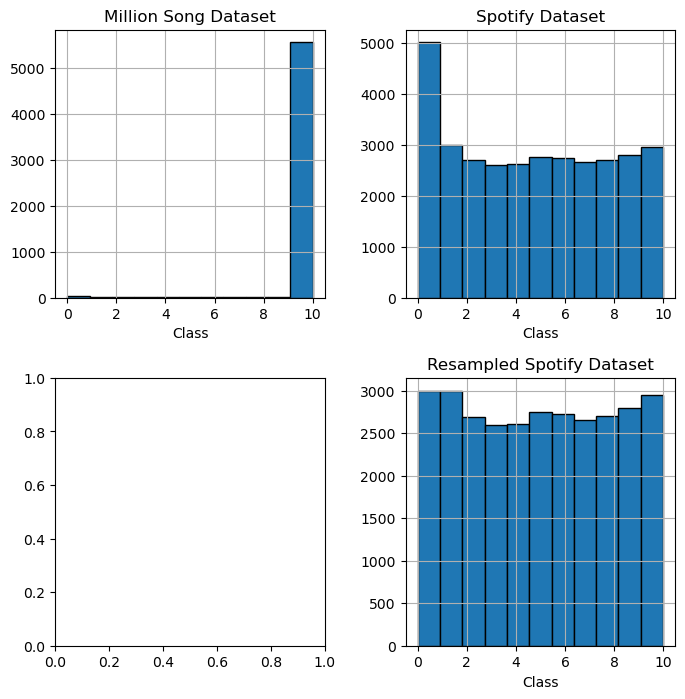

In [7]:
# Read in the data for a quick and dirty histogram view
million_df_hist = pd.read_csv(MILLION_DATA)
spotify_df_hist = pd.read_csv(SPOTIFY_DATA)
spotify_reg_hist = pd.read_csv(RESAMPLED_SPOTIFY_DATA)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Plot histogram of million song dataset
million_df_hist.hist(column="class", ax=ax[0][0], bins=11, edgecolor="k")
ax[0][0].set_title("Million Song Dataset")
ax[0][0].set_xlabel("Class")

# Plot histogram of spotify dataset
spotify_df_hist.hist(column="class", ax=ax[0][1], bins=11, edgecolor="k")
ax[0][1].set_title("Spotify Dataset")
ax[0][1].set_xlabel("Class")

# Plot histogram of resampled spotify dataset
spotify_reg_hist.hist(column="class", ax=ax[1][1], bins=11, edgecolor="k")
ax[1][1].set_title("Resampled Spotify Dataset")
ax[1][1].set_xlabel("Class")


In [15]:
# Read in the data and display sample of 5 rows
df = pd.read_csv("../data/spotify_enhanced_dataset.csv")
df.sample(5, random_state=42)

,song,artist,class,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
4421,Louder Than Love,TKA,6,3ylVpluvCr27SlDvVKiCSY,39,0.685,0.651,6,-10.505,0,0.0386,0.095600,0.108,0.100,0.521,122.064,318893,4
821,Lightnin' Strikes,Lou Christie,0,2OQhFe5jjTnMWaaDRZxz31,41,0.619,0.654,3,-8.460,1,0.0652,0.611000,0.000,0.144,0.688,134.293,181493,4
31864,Bag A l'ame,Cristina Pato Mutenrohi,10,6j30pMZTK8binWFtkYbvWq,2,0.351,0.959,11,-5.997,0,0.0620,0.001810,0.877,0.203,0.517,131.255,334040,4
26190,On My Own,Samantha Barks,9,3Mr6ofzF6ZuYiqHh8qNud3,49,0.338,0.119,0,-15.714,1,0.0632,0.883000,0.000,0.148,0.205,71.842,191067,5
20697,Animal I Have Become,Three Days Grace,5,56sk7jBpZV0CD31G9hEU3b,74,0.553,0.853,8,-3.668,1,0.0339,0.000684,0.000,0.126,0.506,122.023,231400,4


### Train-Test-Val Split

Read in the data and split it.

In [6]:
df = feature_transformer(load_data(SPOTIFY_DATA), SPOTIFY_FEATURES)
train_df, val_df, test_df = split_data(df)
print(f"Train: {train_df.count()}\nTest: {test_df.count()}\nVal: {val_df.count()}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/05 15:04:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Train: 19520
Test: 6531
Val: 6458


### Logistic Regression

#### Hyperparameter search: `regParam`

Using regularization as the hyperparameter variable, train the dataset using Logistic Regression


In [7]:
reg_params = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
lr_reg_params_list = train_estimators(
    train_df,
    LogisticRegression,
    "regParam",
    reg_params,
    featuresCol="features",
    labelCol="class",
)

Training LogisticRegressionModel: uid=LogisticRegression_834352059c91, numClasses=11, numFeatures=14


Training LogisticRegressionModel: uid=LogisticRegression_a984d27bdc1b, numClasses=11, numFeatures=14
Training LogisticRegressionModel: uid=LogisticRegression_c7ac742558ea, numClasses=11, numFeatures=14


Training LogisticRegressionModel: uid=LogisticRegression_bf9e2d8f4e42, numClasses=11, numFeatures=14
Training LogisticRegressionModel: uid=LogisticRegression_b1999250f20a, numClasses=11, numFeatures=14


Training LogisticRegressionModel: uid=LogisticRegression_b103b05fc810, numClasses=11, numFeatures=14


#### Plot estimator scores

We will plot the estimators scores on a graph to determine the best estimator.

CPU times: user 283 ms, sys: 101 ms, total: 384 ms
Wall time: 19.1 s


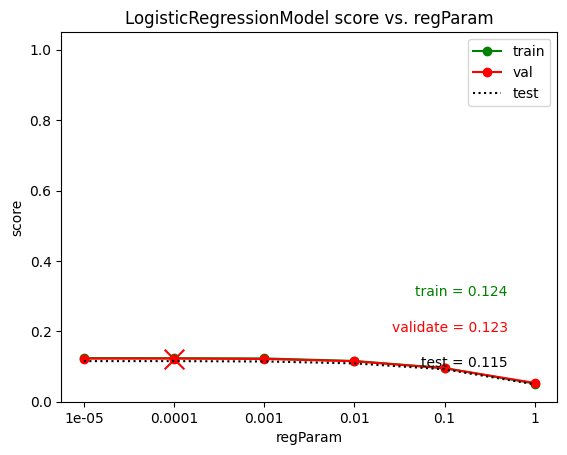

In [9]:
%%time
plot_estimator_scores(
    lr_reg_params_list, "regParam", reg_params, train_df, val_df, test_df
)

### Random Forest Classifier

#### Hyperparameter search: `maxDepth`

Using maxDepth as the hyperparameter, train using RFC.


In [10]:
max_depth = [1, 5, 10, 20, 30]
rfc_trees = train_estimators(
    train_df,
    RandomForestClassifier,
    "maxDepth",
    max_depth,
    featuresCol="features",
    labelCol="class",
    seed=RANDOM_SEED,
)

Training RandomForestClassificationModel: uid=RandomForestClassifier_45f5e6675ba1, numTrees=20, numClasses=11, numFeatures=14
Training RandomForestClassificationModel: uid=RandomForestClassifier_184685c8857e, numTrees=20, numClasses=11, numFeatures=14


Training RandomForestClassificationModel: uid=RandomForestClassifier_2afe5a7a62f3, numTrees=20, numClasses=11, numFeatures=14


Training RandomForestClassificationModel: uid=RandomForestClassifier_c68fcf00b636, numTrees=20, numClasses=11, numFeatures=14


Training RandomForestClassificationModel: uid=RandomForestClassifier_2c7ce5638cc2, numTrees=20, numClasses=11, numFeatures=14


#### Plot estimator scores

We will do the same plotting estimator scores as above.

CPU times: user 238 ms, sys: 148 ms, total: 386 ms
Wall time: 29 s


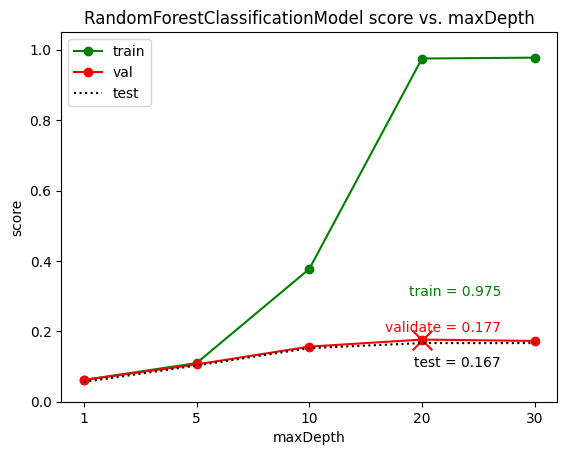

In [11]:
%%time
plot_estimator_scores(rfc_trees, "maxDepth", max_depth, train_df, val_df, test_df)

### Performance evaluation using confusion matrices

Finally, we can compare the performance of each using a confusion matrix.


/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


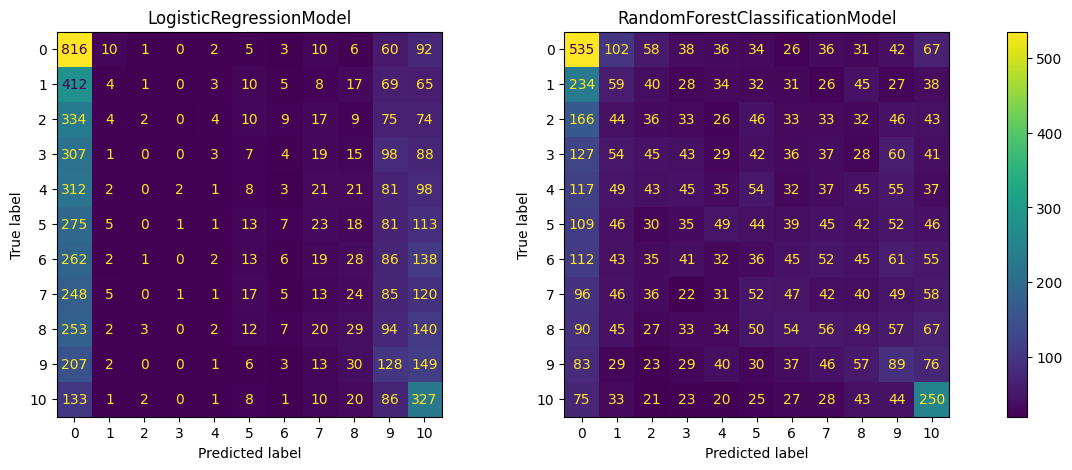

In [12]:
model_list = [lr_reg_params_list, rfc_trees]
generate_confusion_matrix(model_list, val_df, test_df)